In [317]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
import sys
sys.path.append("../")
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns
from simulation import *

### Bivariate Normal Data Generation

In [302]:
from simulation import get_sampler, cls_to_dset, get_train_test_samples
MU = {
    0: [2, 2],
    1: [4, 1],
    2: [3, 5],
    3: [6, 3]
}
std = 0.2
COV = {
    0: np.eye(2)*std**2,
    1: np.eye(2)*std**2,
    2: np.eye(2)*std**2,
    3: np.eye(2)*std**2
}
K = 4
SAMPLERS = get_sampler(MU, COV, K)
# Get SAMPLES
n = 1000
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = get_train_test_samples(SAMPLERS=SAMPLERS, n=n)
# Dataset
IND_CLS = [0, 1, 2]
OOD_CLS = [3]
IND_DATA, IND_X, IND_Y = cls_to_dset(IND_CLS, X_TRAIN, Y_TRAIN)
OOD_DATA, OOD_X, OOD_Y = cls_to_dset(OOD_CLS, X_TRAIN, Y_TRAIN)
IND_DATA_TEST, IND_X_TEST, IND_Y_TEST = cls_to_dset(IND_CLS, X_TEST, Y_TEST)
OOD_DATA_TEST, OOD_X_TEST, OOD_Y_TEST = cls_to_dset(OOD_CLS, X_TEST, Y_TEST)

#### Plot

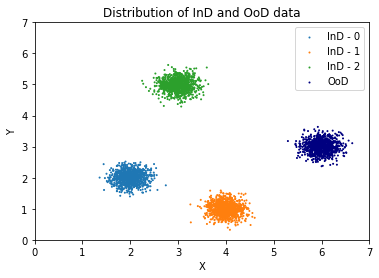

In [303]:
for idx in IND_CLS:
    plt.scatter(IND_X[:,0][IND_Y==idx], IND_X[:,1][IND_Y==idx], label =f"InD - {idx}", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

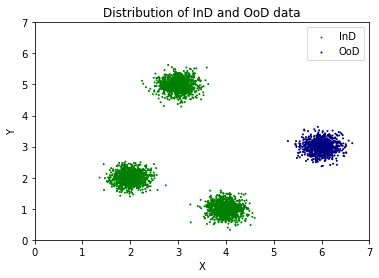

In [304]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='green', label ="InD", sizes=[1]*len(IND_X),alpha=1)
plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label ="OoD", sizes=[1]*len(OOD_X), alpha=1)
plt.xlim((0, 7))
plt.ylim((0, 7))
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Distribution of InD and OoD data")
plt.show()

### Naive Classifier Training

In [305]:
from tqdm import tqdm
from simulation import classifier_training
D = DSIM()
# Configuration
max_epoch = 100
lr = 1e-3
optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D = classifier_training(D, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=50)
torch.save(D.state_dict(), "simulation_log/model/D.pt")

  3%|▎         | 3/100 [00:00<00:07, 13.09it/s]

Epoch  # 1 | Tri loss: 1.0452                     | Tri accuracy: 0.3339
Epoch  # 1 | Val loss: 1.0279                     | Val accuracy: 0.3344


 54%|█████▍    | 54/100 [00:02<00:02, 21.32it/s]

Epoch  # 51 | Tri loss: 0.0502                     | Tri accuracy: 0.9997
Epoch  # 51 | Val loss: 0.0478                     | Val accuracy: 0.9997


100%|██████████| 100/100 [00:04<00:00, 20.72it/s]


#### Plot

torch.Size([10000, 3])


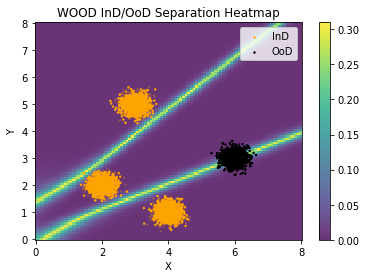

In [306]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_X, 
                    D=D, method="WOOD", m=100)

### WOOD Training

In [310]:
from simulation import *
D_WOOD = DSIM(128)
# OOD data preparation
n_ood = 16
ood_bsz = 16
OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
torch.save(OOD_BATCH, "simulation_log/model/ood_batch.pt")
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
beta = 0.1
optimizer = torch.optim.Adam(D_WOOD.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
D_WOOD = wood_training(D_WOOD, OOD_BATCH, ood_bsz, beta, criterion, optimizer, ind_tri_loader, ind_val_loader, max_epoch, n_epoch=10)

OOD Batch Shape: torch.Size([16, 2])


  1%|          | 1/128 [00:02<04:36,  2.18s/it]

Epoch  # 1 | Tri loss: 1.0231                     | Tri accuracy: 0.3975
Epoch  # 1 | Val loss: 0.9724                     | Val accuracy: 0.6679


  9%|▊         | 11/128 [00:22<03:54,  2.00s/it]

Epoch  # 11 | Tri loss: 0.324                     | Tri accuracy: 0.9706
Epoch  # 11 | Val loss: 0.3494                     | Val accuracy: 0.9729


 16%|█▋        | 21/128 [00:41<03:19,  1.86s/it]

Epoch  # 21 | Tri loss: 0.0703                     | Tri accuracy: 1.0
Epoch  # 21 | Val loss: 0.0932                     | Val accuracy: 1.0


 24%|██▍       | 31/128 [00:59<02:58,  1.84s/it]

Epoch  # 31 | Tri loss: 0.0036                     | Tri accuracy: 1.0
Epoch  # 31 | Val loss: 0.0393                     | Val accuracy: 1.0


 32%|███▏      | 41/128 [01:17<02:40,  1.84s/it]

Epoch  # 41 | Tri loss: -0.0182                     | Tri accuracy: 1.0
Epoch  # 41 | Val loss: 0.0187                     | Val accuracy: 1.0


 40%|███▉      | 51/128 [01:36<02:25,  1.88s/it]

Epoch  # 51 | Tri loss: -0.0237                     | Tri accuracy: 1.0
Epoch  # 51 | Val loss: 0.0124                     | Val accuracy: 1.0


 48%|████▊     | 61/128 [01:55<02:04,  1.85s/it]

Epoch  # 61 | Tri loss: -0.0296                     | Tri accuracy: 1.0
Epoch  # 61 | Val loss: 0.009                     | Val accuracy: 1.0


 55%|█████▌    | 71/128 [02:13<01:45,  1.84s/it]

Epoch  # 71 | Tri loss: -0.0315                     | Tri accuracy: 1.0
Epoch  # 71 | Val loss: 0.0066                     | Val accuracy: 1.0


 63%|██████▎   | 81/128 [02:32<01:26,  1.84s/it]

Epoch  # 81 | Tri loss: -0.0341                     | Tri accuracy: 1.0
Epoch  # 81 | Val loss: 0.0042                     | Val accuracy: 1.0


 71%|███████   | 91/128 [02:50<01:08,  1.86s/it]

Epoch  # 91 | Tri loss: -0.0349                     | Tri accuracy: 1.0
Epoch  # 91 | Val loss: 0.0033                     | Val accuracy: 1.0


 79%|███████▉  | 101/128 [03:08<00:49,  1.82s/it]

Epoch  # 101 | Tri loss: -0.0356                     | Tri accuracy: 1.0
Epoch  # 101 | Val loss: 0.0026                     | Val accuracy: 1.0


 87%|████████▋ | 111/128 [03:27<00:30,  1.81s/it]

Epoch  # 111 | Tri loss: -0.0369                     | Tri accuracy: 1.0
Epoch  # 111 | Val loss: 0.0018                     | Val accuracy: 1.0


 95%|█████████▍| 121/128 [03:45<00:12,  1.82s/it]

Epoch  # 121 | Tri loss: -0.0374                     | Tri accuracy: 1.0
Epoch  # 121 | Val loss: 0.0015                     | Val accuracy: 1.0


100%|██████████| 128/128 [03:58<00:00,  1.86s/it]


torch.Size([10000, 3])


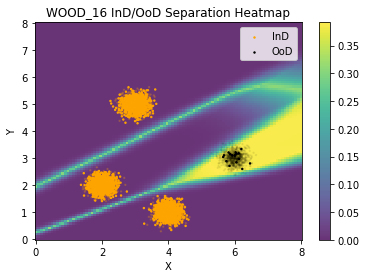

In [311]:
plot_wood = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_WOOD, method="WOOD_16", m=100)

### OOD GAN Training

In [321]:
from simulation import *
D_GAN = DSIM(128)
G_GAN = GSIM(8)
# OOD data preparation
# n_ood = 64
ood_bsz = 16
bsz_tri = 64
# OOD_BATCH = torch.tensor(OOD_X[np.random.choice(n, n_ood, replace=False)], dtype=torch.float32)
print(f"OOD Batch Shape: {OOD_BATCH.shape}")
# Configuration
max_epoch = 128
lr = 1e-3
w_ce, w_wass, w_dist = 1, 0.01, 0.0
n_dim = 1
D_solver = torch.optim.Adam(D_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
G_solver = torch.optim.Adam(G_GAN.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
# Dataset
ind_tri_loader = torch.utils.data.DataLoader(IND_DATA, shuffle=True, batch_size=256)
ind_val_loader = torch.utils.data.DataLoader(IND_DATA_TEST, shuffle=True, batch_size=256)
# Training
oodgan_training(D_GAN, G_GAN, D_solver, G_solver, OOD_BATCH, ood_bsz, bsz_tri, w_ce, w_wass, w_dist,\
                    ind_tri_loader, ind_val_loader, max_epoch, n_epoch=5, n_step_log=10)

OOD Batch Shape: torch.Size([16, 2])


  0%|          | 0/128 [00:00<?, ?it/s]

Step: 0    | D:  1.0613 | CE:  1.0597 | W_OoD:  1.6133 | W_z:  1.0315 | G:  0.0038 | W_z:  0.9663 | dist: 4.4828
Step: 10   | D:  0.9419 | CE:  0.9415 | W_OoD:  1.0668 | W_z:  0.9600 | G:  0.0039 | W_z:  0.9519 | dist: 4.4590


  1%|          | 1/128 [00:22<46:46, 22.10s/it]

Epoch  # 1 | Val accuracy: 0.6676
Step: 8    | D:  0.8627 | CE:  0.8626 | W_OoD:  0.9726 | W_z:  0.9537 | G:  0.0039 | W_z:  0.9523 | dist: 4.4715


  2%|▏         | 2/128 [00:44<46:39, 22.22s/it]

Step: 6    | D:  0.7693 | CE:  0.7693 | W_OoD:  0.9639 | W_z:  0.9472 | G:  0.0039 | W_z:  0.9467 | dist: 4.4461


  2%|▏         | 3/128 [01:07<46:50, 22.48s/it]

Step: 4    | D:  0.8205 | CE:  0.8203 | W_OoD:  0.9684 | W_z:  0.9384 | G:  0.0039 | W_z:  0.9374 | dist: 4.4459


  3%|▎         | 4/128 [01:30<47:15, 22.87s/it]

Step: 2    | D:  0.7428 | CE:  0.7427 | W_OoD:  0.9665 | W_z:  0.9392 | G:  0.0039 | W_z:  0.9361 | dist: 4.4471


  4%|▍         | 5/128 [01:53<46:43, 22.79s/it]

Step: 0    | D:  0.7369 | CE:  0.7368 | W_OoD:  0.9533 | W_z:  0.9401 | G:  0.0039 | W_z:  0.9378 | dist: 4.4425
Step: 10   | D:  0.7412 | CE:  0.7411 | W_OoD:  0.9529 | W_z:  0.9431 | G:  0.0039 | W_z:  0.9438 | dist: 4.4401


  5%|▍         | 6/128 [02:16<46:40, 22.96s/it]

Epoch  # 6 | Val accuracy: 0.7158
Step: 8    | D:  0.6884 | CE:  0.6883 | W_OoD:  0.9642 | W_z:  0.9373 | G:  0.0039 | W_z:  0.9372 | dist: 4.4447


  5%|▌         | 7/128 [02:39<46:11, 22.91s/it]

Step: 6    | D:  0.6925 | CE:  0.6924 | W_OoD:  0.9593 | W_z:  0.9363 | G:  0.0039 | W_z:  0.9361 | dist: 4.4404


  6%|▋         | 8/128 [03:02<45:57, 22.98s/it]

Step: 4    | D:  0.6706 | CE:  0.6706 | W_OoD:  0.9527 | W_z:  0.9363 | G:  0.0039 | W_z:  0.9404 | dist: 4.4426


  7%|▋         | 9/128 [03:25<45:46, 23.08s/it]

Step: 2    | D:  0.6210 | CE:  0.6209 | W_OoD:  0.9518 | W_z:  0.9365 | G:  0.0039 | W_z:  0.9398 | dist: 4.4396


  8%|▊         | 10/128 [03:48<44:55, 22.84s/it]

Step: 0    | D:  0.6606 | CE:  0.6605 | W_OoD:  0.9846 | W_z:  0.9412 | G:  0.0039 | W_z:  0.9395 | dist: 4.4413
Step: 10   | D:  0.6048 | CE:  0.6048 | W_OoD:  0.9486 | W_z:  0.9428 | G:  0.0039 | W_z:  0.9401 | dist: 4.4342


  9%|▊         | 11/128 [04:10<44:17, 22.71s/it]

Epoch  # 11 | Val accuracy: 0.9129
Step: 8    | D:  0.5923 | CE:  0.5920 | W_OoD:  0.9937 | W_z:  0.9382 | G:  0.0039 | W_z:  0.9436 | dist: 4.4332


  9%|▉         | 12/128 [04:33<44:03, 22.79s/it]

Step: 6    | D:  0.6116 | CE:  0.6115 | W_OoD:  0.9605 | W_z:  0.9402 | G:  0.0039 | W_z:  0.9371 | dist: 4.4287


 10%|█         | 13/128 [04:57<44:09, 23.04s/it]

Step: 4    | D:  0.5960 | CE:  0.5959 | W_OoD:  0.9661 | W_z:  0.9350 | G:  0.0039 | W_z:  0.9385 | dist: 4.4324


 11%|█         | 14/128 [05:19<43:20, 22.81s/it]

Step: 2    | D:  0.5641 | CE:  0.5640 | W_OoD:  0.9654 | W_z:  0.9388 | G:  0.0039 | W_z:  0.9385 | dist: 4.4316


 12%|█▏        | 15/128 [05:43<43:39, 23.18s/it]

Step: 0    | D:  0.5304 | CE:  0.5302 | W_OoD:  0.9846 | W_z:  0.9348 | G:  0.0039 | W_z:  0.9342 | dist: 4.4333
Step: 10   | D:  0.5053 | CE:  0.5052 | W_OoD:  0.9651 | W_z:  0.9350 | G:  0.0039 | W_z:  0.9374 | dist: 4.4382


 12%|█▎        | 16/128 [06:05<42:52, 22.97s/it]

Epoch  # 16 | Val accuracy: 0.9727
Step: 8    | D:  0.5237 | CE:  0.5237 | W_OoD:  0.9517 | W_z:  0.9364 | G:  0.0039 | W_z:  0.9389 | dist: 4.4358


 13%|█▎        | 17/128 [06:28<42:02, 22.72s/it]

Step: 6    | D:  0.5017 | CE:  0.5017 | W_OoD:  0.9466 | W_z:  0.9347 | G:  0.0039 | W_z:  0.9354 | dist: 4.4390


 14%|█▍        | 18/128 [06:51<41:54, 22.86s/it]

Step: 4    | D:  0.4525 | CE:  0.4525 | W_OoD:  0.9454 | W_z:  0.9362 | G:  0.0039 | W_z:  0.9349 | dist: 4.4502


 15%|█▍        | 19/128 [07:15<42:10, 23.21s/it]

Step: 2    | D:  0.4617 | CE:  0.4617 | W_OoD:  0.9421 | W_z:  0.9356 | G:  0.0039 | W_z:  0.9351 | dist: 4.4565


 16%|█▌        | 20/128 [07:38<41:59, 23.33s/it]

Step: 0    | D:  0.4854 | CE:  0.4853 | W_OoD:  0.9609 | W_z:  0.9374 | G:  0.0039 | W_z:  0.9383 | dist: 4.4539
Step: 10   | D:  0.4298 | CE:  0.4298 | W_OoD:  0.9528 | W_z:  0.9381 | G:  0.0039 | W_z:  0.9388 | dist: 4.4525


 16%|█▋        | 21/128 [08:01<41:14, 23.13s/it]

Epoch  # 21 | Val accuracy: 0.9904
Step: 8    | D:  0.4418 | CE:  0.4416 | W_OoD:  0.9896 | W_z:  0.9422 | G:  0.0039 | W_z:  0.9426 | dist: 4.4520


 17%|█▋        | 22/128 [08:24<40:38, 23.00s/it]

Step: 6    | D:  0.4177 | CE:  0.4176 | W_OoD:  0.9704 | W_z:  0.9409 | G:  0.0039 | W_z:  0.9381 | dist: 4.4473


 18%|█▊        | 23/128 [08:47<40:32, 23.17s/it]

Step: 4    | D:  0.4289 | CE:  0.4288 | W_OoD:  0.9649 | W_z:  0.9372 | G:  0.0039 | W_z:  0.9368 | dist: 4.4470


 19%|█▉        | 24/128 [09:10<39:48, 22.96s/it]

Step: 2    | D:  0.3786 | CE:  0.3783 | W_OoD:  0.9978 | W_z:  0.9419 | G:  0.0039 | W_z:  0.9442 | dist: 4.4488


 20%|█▉        | 25/128 [09:33<39:20, 22.92s/it]

Step: 0    | D:  0.4036 | CE:  0.4035 | W_OoD:  0.9540 | W_z:  0.9469 | G:  0.0039 | W_z:  0.9464 | dist: 4.4490
Step: 10   | D:  0.3960 | CE:  0.3958 | W_OoD:  0.9714 | W_z:  0.9351 | G:  0.0039 | W_z:  0.9351 | dist: 4.4435


 20%|██        | 26/128 [09:56<39:05, 23.00s/it]

Epoch  # 26 | Val accuracy: 0.9974
Step: 8    | D:  0.3774 | CE:  0.3773 | W_OoD:  0.9526 | W_z:  0.9353 | G:  0.0039 | W_z:  0.9382 | dist: 4.4493


 21%|██        | 27/128 [10:19<38:46, 23.04s/it]

Step: 6    | D:  0.3593 | CE:  0.3593 | W_OoD:  0.9438 | W_z:  0.9371 | G:  0.0039 | W_z:  0.9382 | dist: 4.4555


 22%|██▏       | 28/128 [10:42<38:37, 23.17s/it]

Step: 4    | D:  0.3323 | CE:  0.3323 | W_OoD:  0.9464 | W_z:  0.9381 | G:  0.0039 | W_z:  0.9391 | dist: 4.4537


 23%|██▎       | 29/128 [11:05<38:00, 23.03s/it]

Step: 2    | D:  0.3795 | CE:  0.3793 | W_OoD:  0.9931 | W_z:  0.9469 | G:  0.0039 | W_z:  0.9468 | dist: 4.4541


 23%|██▎       | 30/128 [11:29<38:03, 23.30s/it]

Step: 0    | D:  0.3350 | CE:  0.3345 | W_OoD:  1.0532 | W_z:  0.9366 | G:  0.0039 | W_z:  0.9376 | dist: 4.4557
Step: 10   | D:  0.3234 | CE:  0.3232 | W_OoD:  0.9819 | W_z:  0.9406 | G:  0.0039 | W_z:  0.9433 | dist: 4.4526


 24%|██▍       | 31/128 [11:53<38:08, 23.59s/it]

Epoch  # 31 | Val accuracy: 0.999
Step: 8    | D:  0.3276 | CE:  0.3274 | W_OoD:  0.9783 | W_z:  0.9383 | G:  0.0039 | W_z:  0.9392 | dist: 4.4543


 25%|██▌       | 32/128 [12:15<36:51, 23.04s/it]

Step: 6    | D:  0.3103 | CE:  0.3101 | W_OoD:  0.9965 | W_z:  0.9354 | G:  0.0039 | W_z:  0.9419 | dist: 4.4553


 26%|██▌       | 33/128 [12:38<36:26, 23.02s/it]

Step: 4    | D:  0.3144 | CE:  0.3142 | W_OoD:  0.9912 | W_z:  0.9363 | G:  0.0039 | W_z:  0.9379 | dist: 4.4600


 27%|██▋       | 34/128 [13:02<36:23, 23.22s/it]

Step: 2    | D:  0.2966 | CE:  0.2964 | W_OoD:  0.9761 | W_z:  0.9361 | G:  0.0039 | W_z:  0.9358 | dist: 4.4628


 27%|██▋       | 35/128 [13:26<36:34, 23.60s/it]

Step: 0    | D:  0.2941 | CE:  0.2940 | W_OoD:  0.9466 | W_z:  0.9385 | G:  0.0039 | W_z:  0.9367 | dist: 4.4626
Step: 10   | D:  0.2932 | CE:  0.2932 | W_OoD:  0.9503 | W_z:  0.9376 | G:  0.0039 | W_z:  0.9376 | dist: 4.4614


 28%|██▊       | 36/128 [13:52<37:00, 24.13s/it]

Epoch  # 36 | Val accuracy: 0.9993
Step: 8    | D:  0.2956 | CE:  0.2956 | W_OoD:  0.9512 | W_z:  0.9347 | G:  0.0039 | W_z:  0.9365 | dist: 4.4584


 29%|██▉       | 37/128 [14:17<37:06, 24.47s/it]

Step: 6    | D:  0.2808 | CE:  0.2806 | W_OoD:  0.9979 | W_z:  0.9356 | G:  0.0039 | W_z:  0.9386 | dist: 4.4585


 30%|██▉       | 38/128 [14:40<36:12, 24.14s/it]

torch.Size([10000, 3])


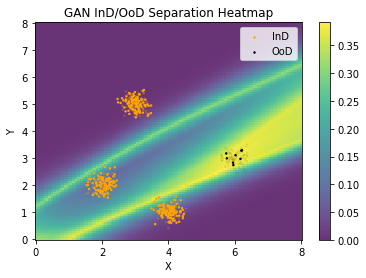

In [ ]:
from simulation import plot_heatmap
plot = plot_heatmap(IND_X=IND_X, IND_X_TEST=IND_X_TEST, OOD_X=OOD_X, OOD_BATCH=OOD_BATCH, 
                    D=D_GAN, method="GAN-16", m=100)

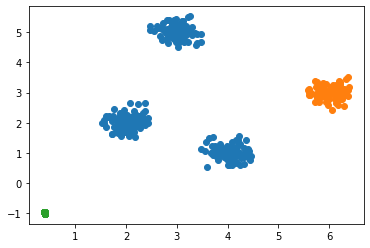

In [ ]:
seed = torch.rand((128, 1))
gz = G_GAN(seed).detach().numpy()
plt.scatter(IND_X[:,0], IND_X[:,1])
plt.scatter(OOD_X[:,0], OOD_X[:,1])
plt.scatter(gz[:,0], gz[:,1])
plt.show()

In [299]:
from simulation import calculate_accuracy
calculate_accuracy(D=D, ind=IND_X, ood=OOD_X, tnr=0.95)

torch.Size([300, 3])
torch.Size([300])
0.00822144187986851
torch.Size([100, 3])
tensor(0.7200)


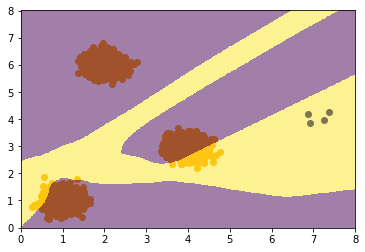

In [90]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)

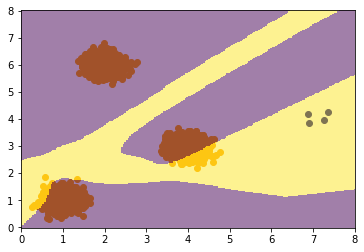

In [88]:
plt.scatter(IND_X[:,0], IND_X[:,1], c='orange', label ="InD", alpha=1)
# plt.scatter(OOD_X[:,0], OOD_X[:,1], c='navy', label="OoD", alpha=0.05)
plt.scatter(OOD_BATCH[:,0], OOD_BATCH[:,1], c='navy', label="OoD", alpha=1)
plt.pcolormesh(xi, yi, mask.reshape((m, m)).T, shading='auto', alpha=0.5)